## Среда POGEMA (Partially Observable Grid Environments for Multiple Agents)

Среда представляет собой клеточное поле с расположенными на нём агентами, их целями и препятствиями. Каждому агенту необходимо добраться до своей цели, избегая препятствий и других агентов. Пример среды, показывающей частичную наблюдаемость для одного агента:

<div>
    <img src="https://raw.githubusercontent.com/Tviskaron/pogema-pics/main/pics/pogema-obs.svg" width="600"/>
</div>

* Наблюдение представляет собой 3 матрицы. Кажда матрица центрирована относительно позиции агента. В качестве наблюдения для всех задач будет использован $R=5$ (поле 11x11 вокруг агента).
* Пространство действий: Агенту доступно 5 действий, движения в 4-ре возможные стороны и пропуск хода.
* Функция вознаграждения: Базовая функция вознаграждения -- это ``0.0`` для всех состояния, пока агент не дошел до цели и ``1.0``, когда дошёл.


## Установка

In [1]:
!pip install -q --quiet pogema

In [2]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pickle  
import gym
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display
import pogema
from pogema import GridConfig

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam 

/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/p

## Пример создания среды

Изменить параметры среды можно передав конфигурационный файл. Параметры, который могут быть вам полезны: 
* size – отвечает за размер окружения
* num_agents – количество агентов в среде
* density - плотность препятствий (рекомендуется использовать значения от 0.2 до 0.4, на них же будет проверяться и ваше решение)
* seed – фиксированное расположения препятствий, агентов и целей. По умолчанию выбирается случайно. Можно поставить None, для случайного выбора. Может быть полезно для проверки результатов.

/usr/local/lib/python3.7/dist-packages/gym/utils/env_checker.py:50: UserWarning: WARN: It seems that your observation  is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  f"It seems that your observation {key} is an image but the `dtype` "
/usr/local/lib/python3.7/dist-packages/gym/utils/env_checker.py:58: UserWarning: WARN: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  f"It seems that your observation space {key} is an image but the "
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is saf

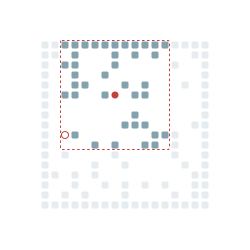

In [4]:
# Define random configuration
grid_config = GridConfig(num_agents=1, # количество агентов на карте
                         size=15,      # размеры карты
                         density=0.2,  # плотность препятствий
                         seed=4,       # сид генерации задания 
                         max_episode_steps=1000,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False, ...]


# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=0)
display(SVG('render.svg'))

# ======= РЕШЕНИЕ =========================================

# Принцип работы
Основан на алгоритме REINFORCE (на данном примере - пока на одном агенте)
У нас есть состояние среды: obs[agent] = ['препятствия', 'положения агентов', 'цели агентов']
Разница между текущей средой и средой за предыдущий шаг - это как раз действия за кадр. Но нам надл в нейросеть передать преграды, поэтому мы поступим так - подадим в нейросеть на вход вектор из двух состояний - предыдущего и текущего, т.е. 2 х (3, 11, 11) -> (2, 3, 11, 11) В нейросети этот вектор пропустим через Flatten() слой и далее обработаем Dense слоями. Эти данные у нас будут на входе нейросети.

На выходе нейросети мы получаем распределение векроятности для действия агента.
Мы берём не argmax, а случайную величину с вероятностью, порпорциональной плотности вероятности для данного действия - так система будет гибче к исследованию среды.

Метрика - **предобработанное вознаграждение** за эпизод. Что такое предобработанное вознаграждение? Мы имеем очень скудные вознаграждения, т.к. оно во-первых назначается в конце эпизода, во вторых - крайне редко статистически для случайных движений агентов (в самаом начале обучения нейросети). Если в ноце эпизода мы получаем вознаграждение - то пробрасываем его обратной итерацией вначальные кадры с коэффициенотм сохранения 0.98 (затухание 2%) и таким образом получаем награду за каждое действие

Особенность - мы не можем разорвать эпизод, поэтому будем обучать батчами, где каждый батч - это эпизод.

## Методы класса:

* **create_model(self)** - создаёт и компилирует модель полносвязной нейросети;
* **fit_episodes(self)** - главный метод обучения можели (на эпизодах);
* **train_model(self, episode_states, episode_actions, episode_rewards)** - обучение модели на эпизоде;
* **preprocess_rewards(self, rewards_list)** - если в конце есть награда - мы раскидываем её на все эпизоды с коэффициентом 0.98 (затухание награды - 2% за действие);
* **get_action(self, state)** - выбор случайного индекса с учётом вероятности predict_proba;
* **def get_state(self, obs_new, obs_old)** - получаем вектор активного состояния, состоящий из 2х векторов - текущего и предыдущего;
* **def show_scores(self, scores_all, scores_episodes_len)** - отображаем метрики на графике
* **def moving_average(self, data, width = 20)** - подсчета скользящего среднего всех значений
    
    

In [5]:
class Model:
    def __init__(self):
        self.agents = None
        self.episode_num = 100  # Количество эпизодов обучения
        self.actions_num = 5  # Количество действий
        self.gamma = 0.98  # Коэффициент сохранения награды от действия к действию при итерации от награды к началу
        self.action_list = [0, 1, 2, 3, 4]  # Список возможных действий
        self.input_shape = (2, 3, 11, 11)
        self.dir = '/content/drive/MyDrive/Colab Notebooks/DAN/robot/hack'
        self.scores_all = []  # Список всех очков за период
        self.scores_episodes_len = []  # Длина игровых эпизодов
        self.first = True
        self.obs_old = False


    def act(self, obs, dones=False, positions_xy=False, targets_xy=False) -> list:
        action_list = []
        for k in range(len(obs)):
            obs_new = obs[k]
            if self.first:
                # Первый проход
                obs_old = obs[k].copy() 
                self.first = False
            else:
                obs_old = self.obs_old

            state = self.get_state([obs_new], [obs_old])
            state = state.reshape(1, 2, 3, 11, 11)
            predict = self.model.predict([state])
            action = np.argmax(predict)
            action_list.append(action)

            self.obs_old = obs_new
        return action_list


    # Создаём модель нейросети
    def create_model(self):
      input = Input(self.input_shape)  # Задаем входную размерность — (2, 3, 11, 11)
      x = Flatten()(input)
      x = Dense(1024, activation = 'elu')(x)
      x = Dense(128, activation = 'elu')(x)
      output = Dense(self.actions_num, activation = 'softmax')(x)

      self.model = tf.keras.models.Model(input, output)   
      self.model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'sparse_categorical_crossentropy') 
      self.model.summary()


    #  Загрузка модели
    def load_model(self):      
        self.model = load_model(f'{self.dir}/REINFORCE.h5')


    # Обучить модель на эпизодах
    def fit_episodes(self):
        episode_num = 0  # Начальный эпизод
        scores_all = []  # Список всех очков за период
        scores_episodes_len = []  # Длина игровых эпизодов

        time_start = time.time()

        # ------- ЦИКЛ ПО ИГРОВЫМ ЭПИЗОДАМ -------
        while episode_num < self.episode_num:
            # Хранилища данных за эпизод
            episode_state_list = []  # Список состояний одного эпизода 
            episode_action_list = []  # Список всех действий за эпизод        
            episode_reward_list = []  # Список всех наград за эпизод 

            obs_new = env.reset()  # Запускаем среду и получаем начальное состояние
            obs_old = obs_new  # Инициализаруем предыдущую среду как текущую

            # state - два плоских вектора суммарного состояния -> предыдущий ход и текущий
            state = self.get_state(obs_new, obs_old)
            # print('STATE:', state.shape)  # (2, 3, 11, 11) - для одного агента
            done = [False, ...]  # Начало игрового периода

            # Пока игровой эпизод не завершен
            # ------- ДЕЙСТВИЯ ВНУТРИ ИГРОВОГО ЭПИЗОДА -------
            frame = 0
            while not all(done):
                action_idx = self.get_action(state)  # Получаем индекс действия по вектору состояния

                # Подаем действие в среду, получаем новый кадр, награду, и узнаем, если игра окончена                                   
                obs_new, reward, done, info = env.step([action_idx])

                # print('ACTION', action_idx, 'REWARD', reward)  

                # --- Добавляем в списки данных за эпизод ---
                episode_state_list.append(state)  # Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод
                episode_action_list.append(action_idx)  # Добавляем действие в массив действий за эпизод              
                episode_reward_list.append(reward)  # Добавляем полученную награду в массив наград за эпизод

                state = self.get_state(obs_new, obs_old)  # Создаём новое состояние, используя следующий шаг, после добавления в массив   

                # Устанавливаем старый кадр как новый кадр (таким образом запоминаем старый кадр)
                obs_old = obs_new 

                # print(f'Кадр: {frame}, done: {done}, {not done}')
                frame += 1

            episode_num += 1  # Следующий эпизод
            episode_timesteps = len(episode_state_list)  # Длина эпизода (количество кадров в эпизоде) равна количеству состояний за эпизод                     

            # List to numpy
            episode_states = np.array(episode_state_list)
            episode_actions = np.array(episode_action_list)
            episode_rewards = np.array(episode_reward_list)

            points_pos = episode_rewards[episode_rewards > 0].size  # Количество положительных наград  
            # points_neg = episode_rewards[episode_rewards < 0].size  # Количество отрицательных наград

            # Обучаем модель, используя состояния в эпизоде, соответствующие действия и награды
            self.train_model(episode_states, episode_actions, episode_rewards)

            # episode_score = points_pos - points_neg  # Очкков за эпизод      
            # scores_all.append(episode_score)  # Добавляем количество очков в список (используется в качестве метрики)
            scores_all.append(points_pos)  # Добавляем количество очков в список (используется в качестве метрики)       
            scores_episodes_len.append(episode_timesteps)  # Добавляем длину эпизода в список (используется в качестве метрики)

            
            # Сохраняем прогресс раз в 10 эпизодов
            if episode_num % 10 == 0:    
                # Сохраняем веса модели
                self.model.save_weights('/content/REINFORCE.h5')   

                # Открываем файл, используя функцию из pickle
                with open('/content/scores.txt', 'wb') as f:  
                    # Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл
                    pickle.dump([scores_all, scores_episodes_len, episode_num], f)  

                # сохраняем анимацию и рисуем ее
                env.save_animation(f'render_{episode_num}_.svg', egocentric_idx=0)
                display(SVG(f'render_{episode_num}_.svg'))  

            # Дополнительно выводим статистику за эпизод через print
            time_delta = round(time.time() - time_start)
            print(f"Закончен {episode_num}-й эпизод, счёт: (агент) {points_pos}, продолжительность игры: {episode_timesteps} кадров. Время выполнения: {time_delta}c.")

        # Отображаем метрики на графике
        self.show_scores(scores_all, scores_episodes_len) 


    # Обучаем модель, используя состояния в эпизоде, соответствующие действия и награды
    def train_model(self, episode_states, episode_actions, episode_rewards):

        # Предобрабатываем награды, используя ранее объявленную функцию  
        rewards = self.preprocess_rewards(episode_rewards)  # Массив обработанных наград

        # Обучаем алгоритм на собранном пакете данных — одном полном эпизоде
        self.model.train_on_batch(episode_states, episode_actions, sample_weight = rewards)


    # Предобработка наград
    # У нас скудные награды - могут быть в самом конце или не быть вообще
    # Если в конце есть награда - мы раскидываем её на все эпизоды с коэффициентом 0.98 (затухание награды - 2% за действие)
    def preprocess_rewards(self, rewards_list):
        discounted_rewards = np.zeros_like(rewards_list)  # Создаём пустой массив
        reward_curr = 0  # Текущая награда за действие, инициализируем                                    
        
        # Итерация в обратном порядке - от получения награды - до конца
        for i in reversed(range(len(discounted_rewards))):    
          
          # Если текущая награда - ненулевая
          if rewards_list[i] != 0:                            
            # переменная reward_curr обнуляется
            reward_curr = 0                                   
          
          # Задаем награду за текущее действие (псевдо-уравнение Беллмана)
          reward_curr = self.gamma * reward_curr + rewards_list[i] 

          # Записываем награду в массив обработанных наград
          discounted_rewards[i] = reward_curr                 
        
        # Возвращаем массив обработанных наград
        return discounted_rewards


    # Получаем индекс действия по вектору состояния
    def get_action(self, state):
        # Делаем предсказание
        predict_proba = self.model.predict(np.expand_dims((state), axis=0))   
        
        # Выбор случайного индекса с учётом вероятности predict_proba
        action_index = np.random.choice(5, p = predict_proba.flatten())  # 5 - количество действий
        
        # Возвращаем индекс рандомно выбранного действия
        return action_index 


    # Получаем вектор активного состояния, состоящий из 2х векторов - текущего и предыдущего, 
    # что бы модель смогла вычислить совершённое действие
    def get_state(self, obs_new, obs_old):
        return np.concatenate([np.array(obs_new), np.array(obs_old)])  # Склеиваем вектора, и возвращаем


    # Отображаем метрики на графике
    def show_scores(self, scores_all, scores_episodes_len):
        # output.clear()  # Удаляем предыдущий вывод ячейки
        
        fig, axes = plt.subplots(1, 2, figsize = (20, 8))                   
        axes[0].plot(scores_all, linestyle = '--', label = 'Награда за эпизод')
        # Считаем и отрисовываем скользящее среднее от награды        
        axes[0].plot(self.moving_average(scores_all), label = 'Скользящее среднее награды')

        # Добавляем лейблы осей  
        axes[0].set_xlabel('Эпизод', fontsize = 12)                                  
        axes[0].set_ylabel('Награда', fontsize = 12)

        # Создаем легенду
        axes[0].legend() 

        # Отрисовываем длину эпизодов
        axes[1].plot(scores_episodes_len, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')

        # Считаем и отрисовываем скользящее среднее по длины эпизода
        axes[1].plot(self.moving_average(scores_episodes_len), 'k', label = 'Длина эпизода (Скользящее среднее)') 

        # Добавляем лейблы осей
        axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            
        axes[1].set_ylabel('Количество действий', fontsize = 12)

        # Создаем легенду
        axes[1].legend()         

        # Выводим график
        plt.show()


    # Функция подсчета скользящего среднего всех значений
    # Аргументы: data — входной массив, width — длина, на которую считаем скользящее среднее
    def moving_average(self, data, width = 20):
        # Длина свертки (минимум из заданной длины свертки и длины датасета)
        width = min(width, len(data))  

        # Вместо паддинга из нулей мы создадим паддинг для свертки из первого значения массива. Весь паддинг будет слева (в начале массива)    
        data = np.concatenate([np.repeat(data[0], width), data])  
        
        # Возвращаем результат свертки данных на фильтр из единиц — наше скользящее среднее
        return (np.convolve(data, np.ones(width), 'valid') / width)[1:]

In [6]:
MODEL = Model()
MODEL.create_model()  # Создаём модель для обучения

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 3, 11, 11)]    0         
                                                                 
 flatten (Flatten)           (None, 726)               0         
                                                                 
 dense (Dense)               (None, 1024)              744448    
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 876,293
Trainable params: 876,293
Non-trainable params: 0
_________________________________________________________________


Закончен 1-й эпизод, счёт: (агент) 1, продолжительность игры: 370 кадров. Время выполнения: 18c.
Закончен 2-й эпизод, счёт: (агент) 0, продолжительность игры: 1000 кадров. Время выполнения: 55c.
Закончен 3-й эпизод, счёт: (агент) 1, продолжительность игры: 454 кадров. Время выполнения: 73c.
Закончен 4-й эпизод, счёт: (агент) 0, продолжительность игры: 1000 кадров. Время выполнения: 110c.
Закончен 5-й эпизод, счёт: (агент) 1, продолжительность игры: 167 кадров. Время выполнения: 117c.
Закончен 6-й эпизод, счёт: (агент) 1, продолжительность игры: 16 кадров. Время выполнения: 117c.
Закончен 7-й эпизод, счёт: (агент) 1, продолжительность игры: 221 кадров. Время выполнения: 126c.
Закончен 8-й эпизод, счёт: (агент) 1, продолжительность игры: 83 кадров. Время выполнения: 129c.
Закончен 9-й эпизод, счёт: (агент) 1, продолжительность игры: 28 кадров. Время выполнения: 130c.


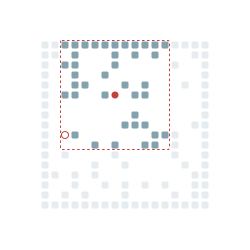

Закончен 10-й эпизод, счёт: (агент) 1, продолжительность игры: 40 кадров. Время выполнения: 131c.
Закончен 11-й эпизод, счёт: (агент) 0, продолжительность игры: 1000 кадров. Время выполнения: 169c.
Закончен 12-й эпизод, счёт: (агент) 1, продолжительность игры: 36 кадров. Время выполнения: 170c.
Закончен 13-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 170c.
Закончен 14-й эпизод, счёт: (агент) 1, продолжительность игры: 71 кадров. Время выполнения: 173c.
Закончен 15-й эпизод, счёт: (агент) 1, продолжительность игры: 73 кадров. Время выполнения: 176c.
Закончен 16-й эпизод, счёт: (агент) 1, продолжительность игры: 47 кадров. Время выполнения: 178c.
Закончен 17-й эпизод, счёт: (агент) 1, продолжительность игры: 37 кадров. Время выполнения: 179c.
Закончен 18-й эпизод, счёт: (агент) 1, продолжительность игры: 46 кадров. Время выполнения: 181c.
Закончен 19-й эпизод, счёт: (агент) 1, продолжительность игры: 24 кадров. Время выполнения: 182c.


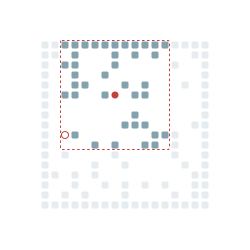

Закончен 20-й эпизод, счёт: (агент) 1, продолжительность игры: 46 кадров. Время выполнения: 183c.
Закончен 21-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 184c.
Закончен 22-й эпизод, счёт: (агент) 1, продолжительность игры: 20 кадров. Время выполнения: 185c.
Закончен 23-й эпизод, счёт: (агент) 1, продолжительность игры: 21 кадров. Время выполнения: 186c.
Закончен 24-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 186c.
Закончен 25-й эпизод, счёт: (агент) 1, продолжительность игры: 21 кадров. Время выполнения: 187c.
Закончен 26-й эпизод, счёт: (агент) 1, продолжительность игры: 15 кадров. Время выполнения: 187c.
Закончен 27-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 188c.
Закончен 28-й эпизод, счёт: (агент) 1, продолжительность игры: 20 кадров. Время выполнения: 189c.
Закончен 29-й эпизод, счёт: (агент) 1, продолжительность игры: 25 кадров. Время выполнения: 189c.


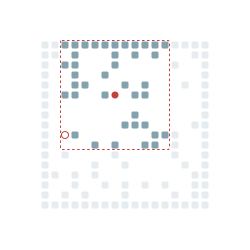

Закончен 30-й эпизод, счёт: (агент) 1, продолжительность игры: 15 кадров. Время выполнения: 190c.
Закончен 31-й эпизод, счёт: (агент) 1, продолжительность игры: 15 кадров. Время выполнения: 191c.
Закончен 32-й эпизод, счёт: (агент) 1, продолжительность игры: 23 кадров. Время выполнения: 192c.
Закончен 33-й эпизод, счёт: (агент) 1, продолжительность игры: 49 кадров. Время выполнения: 194c.
Закончен 34-й эпизод, счёт: (агент) 1, продолжительность игры: 41 кадров. Время выполнения: 195c.
Закончен 35-й эпизод, счёт: (агент) 1, продолжительность игры: 61 кадров. Время выполнения: 197c.
Закончен 36-й эпизод, счёт: (агент) 1, продолжительность игры: 29 кадров. Время выполнения: 199c.
Закончен 37-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 199c.
Закончен 38-й эпизод, счёт: (агент) 1, продолжительность игры: 16 кадров. Время выполнения: 200c.
Закончен 39-й эпизод, счёт: (агент) 1, продолжительность игры: 15 кадров. Время выполнения: 200c.


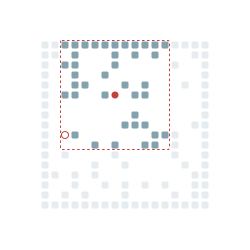

Закончен 40-й эпизод, счёт: (агент) 1, продолжительность игры: 15 кадров. Время выполнения: 201c.
Закончен 41-й эпизод, счёт: (агент) 1, продолжительность игры: 37 кадров. Время выполнения: 202c.
Закончен 42-й эпизод, счёт: (агент) 1, продолжительность игры: 24 кадров. Время выполнения: 203c.
Закончен 43-й эпизод, счёт: (агент) 1, продолжительность игры: 20 кадров. Время выполнения: 204c.
Закончен 44-й эпизод, счёт: (агент) 1, продолжительность игры: 62 кадров. Время выполнения: 206c.
Закончен 45-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 207c.
Закончен 46-й эпизод, счёт: (агент) 1, продолжительность игры: 41 кадров. Время выполнения: 208c.
Закончен 47-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 209c.
Закончен 48-й эпизод, счёт: (агент) 1, продолжительность игры: 36 кадров. Время выполнения: 210c.
Закончен 49-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 211c.


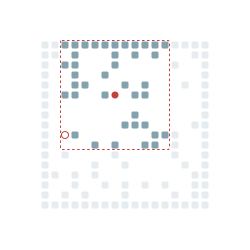

Закончен 50-й эпизод, счёт: (агент) 1, продолжительность игры: 84 кадров. Время выполнения: 214c.
Закончен 51-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 214c.
Закончен 52-й эпизод, счёт: (агент) 1, продолжительность игры: 65 кадров. Время выполнения: 217c.
Закончен 53-й эпизод, счёт: (агент) 1, продолжительность игры: 12 кадров. Время выполнения: 217c.
Закончен 54-й эпизод, счёт: (агент) 1, продолжительность игры: 39 кадров. Время выполнения: 219c.
Закончен 55-й эпизод, счёт: (агент) 1, продолжительность игры: 25 кадров. Время выполнения: 220c.
Закончен 56-й эпизод, счёт: (агент) 1, продолжительность игры: 71 кадров. Время выполнения: 222c.
Закончен 57-й эпизод, счёт: (агент) 1, продолжительность игры: 34 кадров. Время выполнения: 224c.
Закончен 58-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 224c.
Закончен 59-й эпизод, счёт: (агент) 1, продолжительность игры: 12 кадров. Время выполнения: 225c.


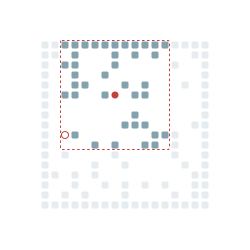

Закончен 60-й эпизод, счёт: (агент) 1, продолжительность игры: 15 кадров. Время выполнения: 225c.
Закончен 61-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 226c.
Закончен 62-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 226c.
Закончен 63-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 227c.
Закончен 64-й эпизод, счёт: (агент) 1, продолжительность игры: 12 кадров. Время выполнения: 227c.
Закончен 65-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 228c.
Закончен 66-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 228c.
Закончен 67-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 229c.
Закончен 68-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 229c.
Закончен 69-й эпизод, счёт: (агент) 1, продолжительность игры: 27 кадров. Время выполнения: 230c.


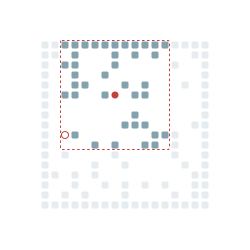

Закончен 70-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 230c.
Закончен 71-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 231c.
Закончен 72-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 231c.
Закончен 73-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 232c.
Закончен 74-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 232c.
Закончен 75-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 232c.
Закончен 76-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 233c.
Закончен 77-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 233c.
Закончен 78-й эпизод, счёт: (агент) 1, продолжительность игры: 13 кадров. Время выполнения: 234c.
Закончен 79-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 234c.


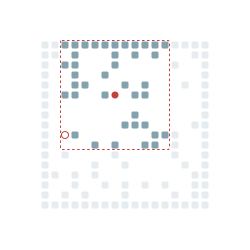

Закончен 80-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 235c.
Закончен 81-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 235c.
Закончен 82-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 235c.
Закончен 83-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 236c.
Закончен 84-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 236c.
Закончен 85-й эпизод, счёт: (агент) 1, продолжительность игры: 14 кадров. Время выполнения: 237c.
Закончен 86-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 237c.
Закончен 87-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 237c.
Закончен 88-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 238c.
Закончен 89-й эпизод, счёт: (агент) 1, продолжительность игры: 14 кадров. Время выполнения: 238c.


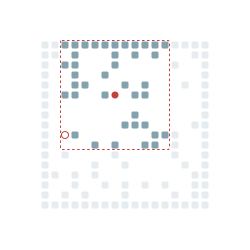

Закончен 90-й эпизод, счёт: (агент) 1, продолжительность игры: 12 кадров. Время выполнения: 239c.
Закончен 91-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 239c.
Закончен 92-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 240c.
Закончен 93-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 240c.
Закончен 94-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 240c.
Закончен 95-й эпизод, счёт: (агент) 1, продолжительность игры: 11 кадров. Время выполнения: 241c.
Закончен 96-й эпизод, счёт: (агент) 1, продолжительность игры: 16 кадров. Время выполнения: 241c.
Закончен 97-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 242c.
Закончен 98-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 242c.
Закончен 99-й эпизод, счёт: (агент) 1, продолжительность игры: 10 кадров. Время выполнения: 242c.


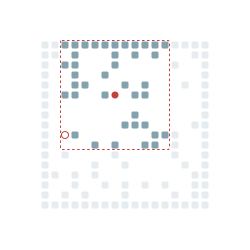

Закончен 100-й эпизод, счёт: (агент) 1, продолжительность игры: 9 кадров. Время выполнения: 243c.


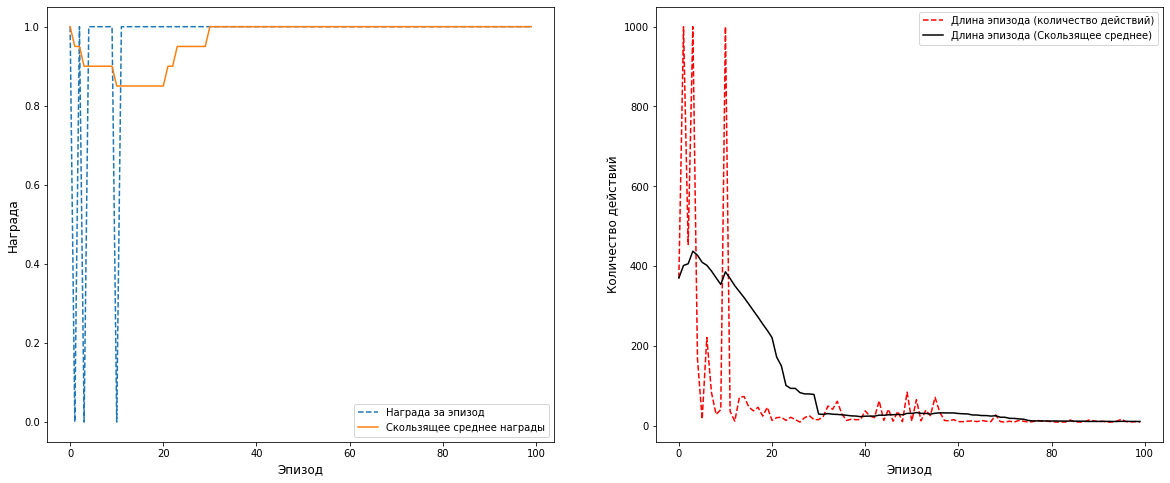

In [7]:
MODEL.fit_episodes()

In [8]:
DIR = '/content/drive/MyDrive/Colab Notebooks/DAN/robot/hack'

In [9]:
MODEL.model.save_weights(f'{DIR}/reinforce_w.h5')
MODEL.model.save(f'{DIR}/REINFORCE.h5')

In [10]:
# MODEL.model.load_weights(f'{DIR}/reinforce_w.h5')
# MODEL.model = load_model(f'{DIR}/REINFORCE.h5')

# Тестирование

In [11]:
MODEL.load_model()

/usr/local/lib/python3.7/dist-packages/gym/utils/env_checker.py:50: UserWarning: WARN: It seems that your observation  is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  f"It seems that your observation {key} is an image but the `dtype` "
/usr/local/lib/python3.7/dist-packages/gym/utils/env_checker.py:58: UserWarning: WARN: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  f"It seems that your observation space {key} is an image but the "
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:620: UserWarning: WARN: Env check failed with the following message: The observation returned by `reset()` method must be a numpy array
You can set `disable_env_checker=True` to

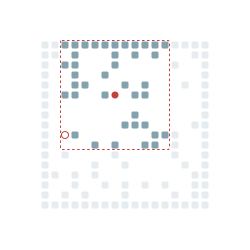

In [12]:
# Define random configuration
grid_config = GridConfig(num_agents=1, # количество агентов на карте
                         size=15,      # размеры карты
                         density=0.2,  # плотность препятствий
                         seed=4,       # сид генерации задания 
                         max_episode_steps=1000,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# обновляем окружение
obs = env.reset()

done = [False, ...]


# сохраняем анимацию и рисуем ее
env.save_animation("render_2.svg", egocentric_idx=0)
display(SVG('render_2.svg'))

In [13]:
MODEL = Model()
MODEL.load_model()

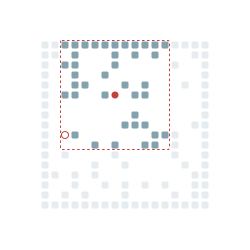

In [14]:
obs = env.reset()
done = [False, ...]

i = 0
while not all(done):
  actions = MODEL.act(obs)
  obs, reward, done, info = env.step(actions)
  i += 1

env.save_animation('test.svg', egocentric_idx=0)
display(SVG('test.svg'))  

# ПРОБЛЕМА
Модель обучилась находить путь для данного поля с данными характеристиками, но стоит изменить параметры - и ничего не получается. Поэтому, что бы не было привыкания к конкретному полю - нужно запускать модель на тысячах различных полей и с разными характеристиками, в каждом запуске от 100 эпизодов, и в каждом может быть до 1000 кадров.

Одно поле - около 600 секунд.
Обучение на 10 000 полей (для нейронной сети - это немного) - займёт около 1666 чаов - 69 дней.

Если применить чередование сред не дожидаясь оптимального обучения на конкретной среде, то первые эпохи обучения будут занимать около 1000 кадров на один эпизод, т.к. нейросеть необучена и веса - практически - случайны. Это может даже увеличить время обучения.

# ==========================================================